In [1]:
from binance.client import Client
import pandas as pd
import yfinance as yf
import requests
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import time
from binance.enums import *


In [ ]:
#Données de refinitiv workspace si besoin
# import cufflinks as cf 
# import refinitiv.data as rd
# rd.open_session()
# cf.set_config_file(offline=True)  # set the plotting mode to offline

In [2]:
# api_key = ' API '
# api_secret = 'API secrete'

# client = Client(api_key, api_secret)

In [ ]:
# def get_close_data(symbol, interval, start_str, end_str=None):
#     """
#     Récupère uniquement les données de clôture pour un symbole donné via l'API Binance.
#     """
#     klines = client.get_historical_klines(symbol, interval, start_str, end_str)
#     # Extraire uniquement les colonnes utiles : "Open time" et "Close"
#     data = pd.DataFrame(klines, columns=['Open time', 'Close'] + ['_']*10)
#     data['Open time'] = pd.to_datetime(data['Open time'], unit='ms')
#     data.set_index('Open time', inplace=True)
#     data['Close'] = data['Close'].astype(float)
#     return data[['Close']]

# # Définir la période et l'intervalle
# start_date = "2024-03-31"
# end_date = "2025-02-15"
# interval = Client.KLINE_INTERVAL_1MINUTE

# # Récupérer uniquement les données de clôture pour ETH et SFP
# df_eth = get_close_data("ETHUSDT", interval, start_date, end_date)
# df_sfp = get_close_data("SFPUSDT", interval, start_date, end_date)

# # Renommer les colonnes pour différencier
# df_eth.rename(columns={'Close': 'Close_ETH'}, inplace=True)
# df_sfp.rename(columns={'Close': 'Close_SFP'}, inplace=True)

# # Fusionner les deux DataFrames sur l'index temporel
# df = pd.merge_asof(df_eth.sort_index(), df_sfp.sort_index(), left_index=True, right_index=True)

# # Calculer le spread et le z-score avec une fenêtre glissante (ici 60 minutes)
# df['spread'] = df['Close_ETH'] - df['Close_SFP']
# window = 60
# df['spread_mean'] = df['spread'].rolling(window).mean()
# df['spread_std'] = df['spread'].rolling(window).std()
# df['spread_zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

# df.dropna(inplace=True)
# print(df.head())

In [71]:
#df.to_csv("dataset_crypto_projet.csv")

In [2]:
df = pd.read_csv("dataset_crypto_projet.csv", parse_dates=['Open time'])
df.set_index('Open time', inplace=True)
# Calculer le spread et le z-score avec une fenêtre glissante (ici 60 minutes)
df['spread'] = df['Close_ETH'] - df['Close_SFP']
window = 60
df['spread_mean'] = df['spread'].rolling(window).mean()
df['spread_std'] = df['spread'].rolling(window).std()
df['spread_zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

df.dropna(inplace=True)
print(df.head())

                     Close_ETH  Close_SFP       spread  spread_mean  \
Open time                                                             
2024-03-31 02:57:00  3568.9966   0.755073  3568.241527  3566.719516   
2024-03-31 02:58:00  3568.0068   0.755172  3567.251628  3566.897522   
2024-03-31 02:59:00  3568.3199   0.755865  3567.564035  3567.048761   
2024-03-31 03:00:00  3567.5321   0.756162  3566.775938  3567.198480   
2024-03-31 03:01:00  3566.9968   0.756162  3566.240638  3567.364350   

                     spread_std  spread_zscore  
Open time                                       
2024-03-31 02:57:00    5.986835       0.254226  
2024-03-31 02:58:00    5.836885       0.060667  
2024-03-31 02:59:00    5.731957       0.089895  
2024-03-31 03:00:00    5.601938      -0.075428  
2024-03-31 03:01:00    5.417735      -0.207414  


In [3]:
df_sim = df

In [15]:
def strategie(df, fee=0.0005, stoploss=-0.03, entry_offset=0.4):
    """
    Cette fonction parcourt le DataFrame 'df' (qui doit contenir 'spread' et 'spread_zscore')
    en utilisant des fenêtres successives de 3 jours. Pour chaque fenêtre :

      1) Je teste plusieurs valeurs de seuil et je retiens celle qui offre la 
         meilleure performance (calculée via un Sharpe ratio).
      2) J'applique ensuite ce seuil sur les 3 jours qui suivent afin de mesurer
         le rendement et le Sharpe effectif.

    La fonction retourne un DataFrame résumant les seuils et résultats obtenus.
    """

    def simule_pour_entrainement(df_period, threshold):
        """
        Sur df_period, je simule un ensemble de règles pour un 'threshold' donné.
        J'enregistre ensuite le rendement total et le Sharpe ratio obtenus.
        """
        df_sim = df_period.copy().reset_index(drop=False)
        positions = []
        pos = 0
        trade_entry = None

        for idx, row in df_sim.iterrows():
            z = row['spread_zscore']
            current_spread = row['spread']

            if pos == 0:
                # Conditions d'entrée
                if z > (threshold + entry_offset):
                    pos = -1
                    trade_entry = current_spread
                elif z < -(threshold + entry_offset):
                    pos = 1
                    trade_entry = current_spread
            else:
                # Calcul du rendement cumulé pour gérer le stoploss et la sortie
                if trade_entry is not None:
                    if pos == -1:
                        cum_return = (current_spread / trade_entry - 1) * (-1)
                    else:
                        cum_return = (current_spread / trade_entry - 1)
                else:
                    cum_return = 0

                # Stop-loss
                if cum_return < stoploss:
                    pos = 0
                    trade_entry = None
                else:
                    # Conditions de sortie
                    if pos == -1 and z < threshold:
                        pos = 0
                        trade_entry = None
                    elif pos == 1 and z > -threshold:
                        pos = 0
                        trade_entry = None

            positions.append(pos)

        df_sim['position'] = positions
        df_sim['position_shifted'] = df_sim['position'].shift(1)
        df_sim['spread_return'] = df_sim['spread'].pct_change().shift(-1)
        df_sim['position_change'] = df_sim['position'].diff().abs().fillna(0)

        # Calcul du rendement de la stratégie
        df_sim['strategy_return'] = (
            df_sim['position_shifted'] * df_sim['spread_return']
            - fee * df_sim['position_change']
        )

        total_return = df_sim['strategy_return'].sum()
        strategy_returns = df_sim['strategy_return'].dropna()
        sharpe = strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else -np.inf

        return total_return, sharpe

    def simule_pour_trading(df_period, threshold):
        """
        J'applique le seuil choisi (optimal) sur df_period, et je retourne 
        le rendement et le Sharpe ratio réels pour cette période.
        """
        df_sim = df_period.copy().reset_index(drop=False)
        positions = []
        pos = 0
        trade_entry = None

        for idx, row in df_sim.iterrows():
            z = row['spread_zscore']
            current_spread = row['spread']

            if pos == 0:
                if z > (threshold + entry_offset):
                    pos = 1
                    trade_entry = current_spread
                elif z < -(threshold + entry_offset):
                    pos = -1
                    trade_entry = current_spread
            else:
                if trade_entry is not None:
                    if pos == 1:
                        cum_return = (current_spread / trade_entry - 1) * (-1)
                    else:
                        cum_return = (current_spread / trade_entry - 1) 
                else:
                    cum_return = 0

                # Stop-loss
                if cum_return < stoploss:
                    pos = 0
                    trade_entry = None
                else:
                    # Sortie
                    if pos == 1 and z < threshold:
                        pos = 0
                        trade_entry = None
                    elif pos == -1 and z > -threshold:
                        pos = 0
                        trade_entry = None

            positions.append(pos)

        df_sim['position'] = positions
        df_sim['position_shifted'] = df_sim['position'].shift(1)
        df_sim['spread_return'] = df_sim['spread'].pct_change().shift(-1)
        df_sim['position_change'] = df_sim['position'].diff().abs().fillna(0)

        # Calcul du rendement de la stratégie
        df_sim['strategy_return'] = (
            df_sim['position_shifted'] * df_sim['spread_return']
            - fee * df_sim['position_change']
        )

        total_return = df_sim['strategy_return'].sum()
        strategy_returns = df_sim['strategy_return'].dropna()
        sharpe = strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else -np.inf

        return total_return, sharpe

    # Boucle pour parcourir les fenêtres de 3 jours
    dates = df.index.normalize().unique()
    results = []
    i = 0

    while i < len(dates) - 3:
        window_start = dates[i]
        window_end = window_start + pd.Timedelta(days=3)
        window_df = df.loc[window_start:window_end]
        
        # Vérification de la quantité de données
        if window_df.empty or (window_df.index[-1] - window_df.index[0]).days < 2:
            i += 1
            continue
        
        best_threshold = None
        best_sharpe = -np.inf
        best_return = None
        
        # 1) Recherche du seuil optimal
        for th in np.arange(3.5, 6.5, 0.1):
            tot_return, sharpe = simule_pour_entrainement(window_df, th)
            if tot_return > 0 and sharpe > best_sharpe:
                best_sharpe = sharpe
                best_threshold = th
                best_return = tot_return

        if best_threshold is None:
            i += 1
            continue
        
        # 2) Application de la stratégie sur la période suivante
        target_start = window_end
        target_end = target_start + pd.Timedelta(days=3)
        target_df = df.loc[target_start:target_end]
        
        if target_df.empty:
            target_return = np.nan
        else:
            target_return, _ = simule_pour_trading(target_df, best_threshold)
        
        results.append({
            'window_start': window_start,
            'window_end': window_end,
            'optimal_threshold': best_threshold,
            'window_sharpe': best_sharpe,
            'window_return': best_return,
            'target_start': target_start,
            'target_end': target_end,
            'target_return': target_return
        })
        
        i += 1

    df_results = pd.DataFrame(results)
    df_results['window_start'] = pd.to_datetime(df_results['window_start'])
    df_results.set_index('window_start', inplace=True)
    return df_results




In [16]:
# ==========================
#appel de la fonction
# ==========================

df_results = strategie(df) 
print(df_results.head())
df_results.to_csv("df_results.csv")

             window_end  optimal_threshold  window_sharpe  window_return  \
window_start                                                               
2024-04-05   2024-04-08                3.6       0.012603       0.003546   
2024-04-06   2024-04-09                4.0       0.011647       0.002142   
2024-04-10   2024-04-13                4.9       0.002458       0.001447   
2024-04-11   2024-04-14                4.9       0.002458       0.001447   
2024-04-12   2024-04-15                4.5       0.002458       0.001447   

             target_start target_end  target_return  
window_start                                         
2024-04-05     2024-04-08 2024-04-11      -0.008365  
2024-04-06     2024-04-09 2024-04-12       0.001818  
2024-04-10     2024-04-13 2024-04-16       0.000000  
2024-04-11     2024-04-14 2024-04-17       0.000000  
2024-04-12     2024-04-15 2024-04-18      -0.002459  


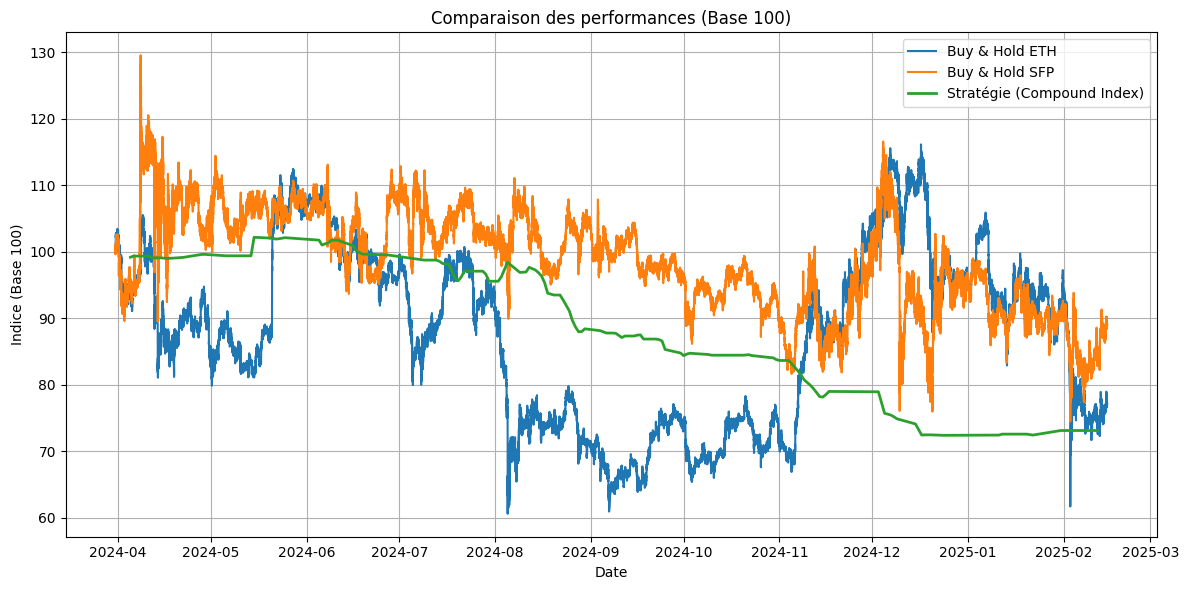

In [22]:
pd.read_csv('df_results.csv')
# 1. Calculer l'indice de la stratégie (en base 100)
df_results_clean = df_results.dropna(subset=['target_return']).copy()
df_results_clean['strategy_index'] = 100 * (1 + df_results_clean['target_return']).cumprod()

# 2. Calculer l'indice Buy & Hold pour ETH et SFP
# Utiliser la première date de votre DataFrame comme base
base_date = df.index.min()
base_ETH = df.loc[base_date, 'Close_ETH']
base_SFP = df.loc[base_date, 'Close_SFP']

df['Index_ETH'] = df['Close_ETH'] / base_ETH * 100
df['Index_SFP'] = df['Close_SFP'] / base_SFP * 100

# 3. Tracer les trois courbes sur un même graphique
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Index_ETH'], label="Buy & Hold ETH", linewidth=1.5)
plt.plot(df.index, df['Index_SFP'], label="Buy & Hold SFP", linewidth=1.5)
plt.plot(df_results_clean.index, df_results_clean['strategy_index'], label="Stratégie (Compound Index)", linewidth=2)
plt.title("Comparaison des performances (Base 100)")
plt.xlabel("Date")
plt.ylabel("Indice (Base 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

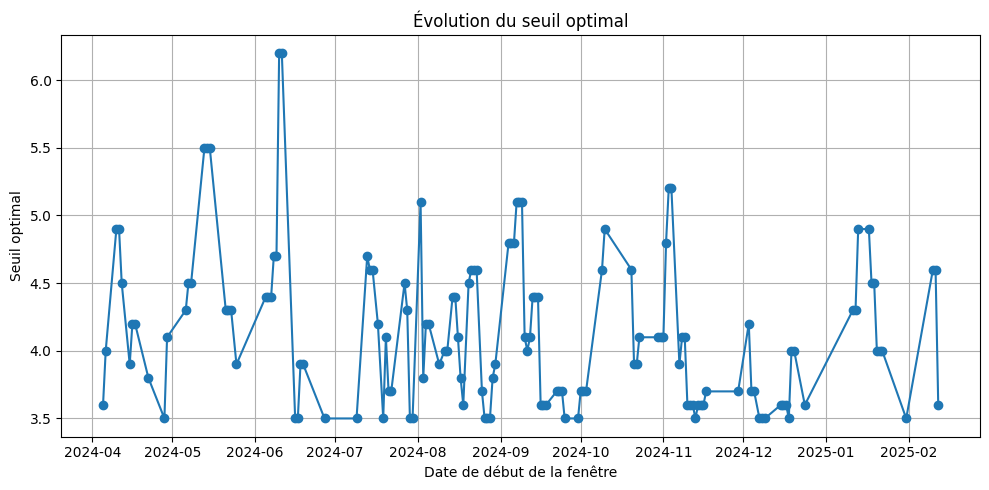

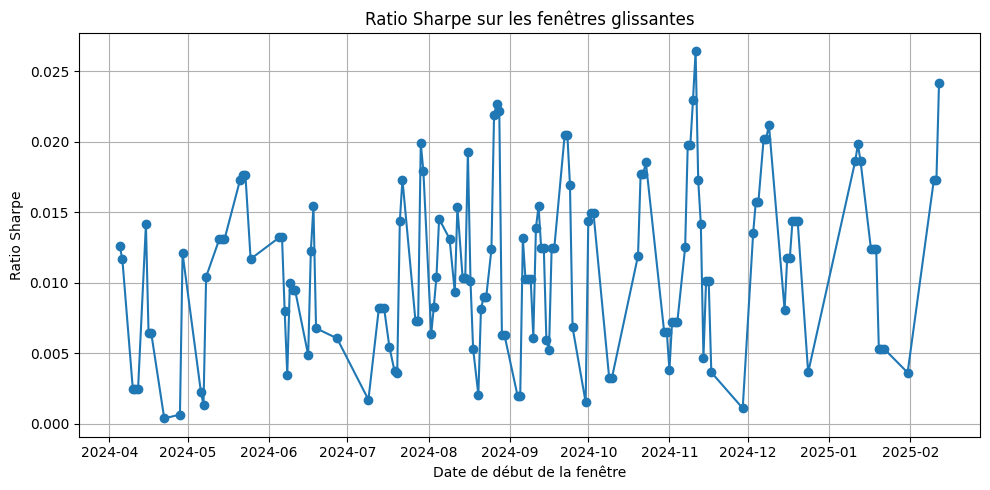

In [21]:


# Graphique 2 : Évolution du seuil optimal au fil du temps
plt.figure(figsize=(10,5))
plt.plot(df_results.index, df_results['optimal_threshold'], marker='o', linestyle='-')
plt.title("Évolution du seuil optimal")
plt.xlabel("Date de début de la fenêtre")
plt.ylabel("Seuil optimal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Graphique 3 : Ratio Sharpe par fenêtre
plt.figure(figsize=(10,5))
plt.plot(df_results.index, df_results['window_sharpe'], marker='o', linestyle='-')
plt.title("Ratio Sharpe sur les fenêtres glissantes")
plt.xlabel("Date de début de la fenêtre")
plt.ylabel("Ratio Sharpe")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
#  Calcul d'un ratio de sharpe total sur la série de 'target_return'
returns_series = df_results['target_return'].dropna()
if returns_series.std() == 0:
    sharpe_global = np.nan
else:
    sharpe_global = returns_series.mean() / returns_series.std()
print(f"Sharpe ratio global            : {sharpe_global:.3f}")

Sharpe ratio global            : -0.345


***Pour l'implementation en direct sur Binance Testnet***

In [ ]:
# api_key = 'API Binancetestnet'
# api_secret = 'api secret'
# client = Client(api_key, api_secret, testnet=True)

In [ ]:
# #Exemple de code pour l'implementation

# # API
# API_KEY = "TON_API_KEY_TESTNET"
# API_SECRET = "TON_SECRET_TESTNET"

# # Initialisation du client Binance en mode testnet 
# # Pour le testnet spot, endpoint = https://testnet.binance.vision
# client = Client(API_KEY, API_SECRET)
# client.API_URL = 'https://testnet.binance.vision/api'  # For Spot Testnet

# ##########################
# # STRATÉGIE
# ##########################

# def strategie(df, fee=0.0005, stoploss=-0.03, entry_offset=0.4):
#     """
#    Stratégie de trading
#     """
#     def simule_pour_entrainement(df_period, threshold):
#         df_sim = df_period.copy().reset_index(drop=False)
#         positions = []
#         pos = 0
#         trade_entry = None

#         for idx, row in df_sim.iterrows():
#             z = row['spread_zscore']
#             current_spread = row['spread']

#             if pos == 0:
#                 if z > (threshold + entry_offset):
#                     pos = -1
#                     trade_entry = current_spread
#                 elif z < -(threshold + entry_offset):
#                     pos = 1
#                     trade_entry = current_spread
#             else:
#                 if trade_entry is not None:
#                     if pos == -1:
#                         cum_return = (current_spread / trade_entry - 1) * (-1)
#                     else:
#                         cum_return = (current_spread / trade_entry - 1)
#                 else:
#                     cum_return = 0

#                 if cum_return < stoploss:
#                     pos = 0
#                     trade_entry = None
#                 else:
#                     if pos == -1 and z < threshold:
#                         pos = 0
#                         trade_entry = None
#                     elif pos == 1 and z > -threshold:
#                         pos = 0
#                         trade_entry = None

#             positions.append(pos)

#         df_sim['position'] = positions
#         df_sim['position_shifted'] = df_sim['position'].shift(1)
#         df_sim['spread_return'] = df_sim['spread'].pct_change().shift(-1)
#         df_sim['position_change'] = df_sim['position'].diff().abs().fillna(0)

#         df_sim['strategy_return'] = (
#             df_sim['position_shifted'] * df_sim['spread_return']
#             - fee * df_sim['position_change']
#         )

#         total_return = df_sim['strategy_return'].sum()
#         strategy_returns = df_sim['strategy_return'].dropna()
#         sharpe = strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else -np.inf
#         return total_return, sharpe

#     def simule_pour_trading(df_period, threshold):
#         df_sim = df_period.copy().reset_index(drop=False)
#         positions = []
#         pos = 0
#         trade_entry = None

#         for idx, row in df_sim.iterrows():
#             z = row['spread_zscore']
#             current_spread = row['spread']

#             if pos == 0:
#                 if z > (threshold + entry_offset):
#                     pos = 1
#                     trade_entry = current_spread
#                 elif z < -(threshold + entry_offset):
#                     pos = -1
#                     trade_entry = current_spread
#             else:
#                 if trade_entry is not None:
#                     if pos == 1:
#                         cum_return = (current_spread / trade_entry - 1) * (-1)
#                     else:
#                         cum_return = (current_spread / trade_entry - 1)
#                 else:
#                     cum_return = 0

#                 if cum_return < stoploss:
#                     pos = 0
#                     trade_entry = None
#                 else:
#                     if pos == 1 and z < threshold:
#                         pos = 0
#                         trade_entry = None
#                     elif pos == -1 and z > -threshold:
#                         pos = 0
#                         trade_entry = None

#             positions.append(pos)

#         df_sim['position'] = positions
#         df_sim['position_shifted'] = df_sim['position'].shift(1)
#         df_sim['spread_return'] = df_sim['spread'].pct_change().shift(-1)
#         df_sim['position_change'] = df_sim['position'].diff().abs().fillna(0)

#         df_sim['strategy_return'] = (
#             df_sim['position_shifted'] * df_sim['spread_return']
#             - fee * df_sim['position_change']
#         )

#         total_return = df_sim['strategy_return'].sum()
#         strategy_returns = df_sim['strategy_return'].dropna()
#         sharpe = strategy_returns.mean() / strategy_returns.std() if strategy_returns.std() != 0 else -np.inf
#         return total_return, sharpe

#     dates = df.index.normalize().unique()
#     results = []
#     i = 0

#     while i < len(dates) - 3:
#         window_start = dates[i]
#         window_end = window_start + pd.Timedelta(days=3)
#         window_df = df.loc[window_start:window_end]
        
#         if window_df.empty or (window_df.index[-1] - window_df.index[0]).days < 2:
#             i += 1
#             continue
        
#         best_threshold = None
#         best_sharpe = -np.inf
#         best_return = None
        
#         for th in np.arange(3.5, 6.5, 0.1):
#             tot_return, sharpe = simule_pour_entrainement(window_df, th)
#             if tot_return > 0 and sharpe > best_sharpe:
#                 best_sharpe = sharpe
#                 best_threshold = th
#                 best_return = tot_return

#         if best_threshold is None:
#             i += 1
#             continue
        
#         target_start = window_end
#         target_end = target_start + pd.Timedelta(days=3)
#         target_df = df.loc[target_start:target_end]
        
#         if target_df.empty:
#             target_return = np.nan
#         else:
#             target_return, _ = simule_pour_trading(target_df, best_threshold)
        
#         results.append({
#             'window_start': window_start,
#             'window_end': window_end,
#             'optimal_threshold': best_threshold,
#             'window_sharpe': best_sharpe,
#             'window_return': best_return,
#             'target_start': target_start,
#             'target_end': target_end,
#             'target_return': target_return
#         })
        
#         i += 1

#     df_results = pd.DataFrame(results)
#     df_results['window_start'] = pd.to_datetime(df_results['window_start'])
#     df_results.set_index('window_start', inplace=True)
#     return df_results


# df_results = strategie(df)
# print(df_results.head())

# ##########################
# # EXEMPLE DE PASSAGE D'ORDRES SUR LE TESTNET
# ##########################

# #
# #   - Quand strategy nous dit "pos = +1" => on achète 
# #   - Quand strategy nous dit "pos = -1" => on vend 
# # 
# #   - un BUY sur un actif 
# #   - un SELL sur l'autre
# #
# # Illustration d'un ordre avec un signal fake de test

# symbol_to_trade = "ETHUSDT"  # Sur testnet


# fake_pos_signal = +1  # Ex: la stratégie dit "pos = +1"

# if fake_pos_signal == 1:
#     print("=== On place un ordre MARKET BUY ===")
#     order = client.create_order(
#         symbol=symbol_to_trade,
#         side=SIDE_BUY,
#         type=ORDER_TYPE_MARKET,
#         quantity=0.01  
#     )
# elif fake_pos_signal == -1:
#     print("=== On place un ordre MARKET SELL ===")
#     order = client.create_order(
#         symbol=symbol_to_trade,
#         side=SIDE_SELL,
#         type=ORDER_TYPE_MARKET,
#         quantity=0.01  
#     )

# print("Ordre exécuté :", order)
